In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LeakyReLU,Dropout
from tensorflow.keras.optimizers import Adam


2024-11-21 03:09:49.139589: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 03:09:49.143100: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 03:09:49.153087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732138789.170278  580323 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732138789.175260  580323 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 03:09:49.193092: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, header=None, names=columns)

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:


def build_generator(latent_dim, n_features):
    model = Sequential([
        Dense(128, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(n_features, activation='linear')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [5]:
def build_discriminator(n_features):
    model = Sequential([
        Dense(256, input_dim=n_features),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [6]:
#combining discriminator and generator
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])
    model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')
    return model

In [7]:
latent_dim = 100
n_features = X_train.shape[1]

generator = build_generator(latent_dim, n_features)
discriminator = build_discriminator(n_features)
gan = build_gan(generator, discriminator)

def train_gan(gan, generator, discriminator, X_real, epochs=20000, batch_size=64):
    # Ensure models are compiled
    if not discriminator.compiled_metrics:
        raise RuntimeError("Discriminator model is not compiled. Please compile it before training.")

    for epoch in range(epochs):
        # Generate real and fake samples
        idx = np.random.randint(0, X_real.shape[0], batch_size)
        X_real_samples = X_real[idx]
        y_real = np.ones((batch_size, 1))  # Label for real data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        X_fake_samples = generator.predict(noise)
        y_fake = np.zeros((batch_size, 1))  # Label for fake data

        # Train discriminator
        try:
            discriminator_loss_real = discriminator.train_on_batch(X_real_samples, y_real)
            discriminator_loss_fake = discriminator.train_on_batch(X_fake_samples, y_fake)
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
        except AttributeError as e:
            print("AttributeError in discriminator training:", e)
            return

        # Train generator
        try:
            y_gan = np.ones((batch_size, 1))  # Generator aims to fool the discriminator
            generator_loss = gan.train_on_batch(noise, y_gan)
        except Exception as e:
            print("Error during generator training:", e)
            return

        # Print progress
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}')


train_gan(gan, generator, discriminator, X_train)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/home/bhav/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bhav/miniconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2024-11-21 03:09:50.970405: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


AttributeError in discriminator training: 'NoneType' object has no attribute 'update_state'


In [8]:
# Generate synthetic samples
noise = np.random.normal(0, 1, (len(X_train), latent_dim))
X_synthetic = generator.predict(noise)
y_synthetic = np.ones(len(X_synthetic))  # Use synthetic labels as '1'


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [9]:
X_combined = np.vstack((X_train, X_synthetic))
y_combined = np.hstack((y_train, y_synthetic))


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build ANN model
def build_ann(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

ann = build_ann(X_combined.shape[1])

# Train ANN
ann.fit(X_combined, y_combined, epochs=500, batch_size=64, validation_split=0.2)


Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5973 - loss: 0.6630 - val_accuracy: 1.0000 - val_loss: 0.3999
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7379 - loss: 0.5555 - val_accuracy: 0.9959 - val_loss: 0.2165
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7596 - loss: 0.4868 - val_accuracy: 1.0000 - val_loss: 0.1052
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7654 - loss: 0.4544 - val_accuracy: 1.0000 - val_loss: 0.0579
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7677 - loss: 0.4330 - val_accuracy: 1.0000 - val_loss: 0.0399
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7775 - loss: 0.4128 - val_accuracy: 1.0000 - val_loss: 0.0321
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7891 - loss: 0.4073 - val_accuracy: 1.0000 - val_loss: 0.0271
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7811 - loss: 0.4000 - val_accuracy: 1.0000 - v

In [11]:
# Evaluate on test set
# loss, accuracy = ann.evaluate(X_test, y_test)
# print(f"Test Accuracy: {accuracy:.2f}")

y_pred=ann.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(int)
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test,y_pred_bin)
print(f"Test Accuracy: {acc:.2f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Test Accuracy: 0.73


In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
cv_accuracies = []

# Perform cross-validation
for train_index, val_index in kf.split(X_combined):
    X_train_cv, X_val_cv = X_combined[train_index], X_combined[val_index]
    y_train_cv, y_val_cv = y_combined[train_index], y_combined[val_index]
    
    # Build and compile the ANN model
    ann_cv = build_ann(X_combined.shape[1])
    
    # Train the model
    ann_cv.fit(X_train_cv, y_train_cv, epochs=500, batch_size=64, verbose=0)
    
    # Evaluate the model on the validation set
    y_val_pred = ann_cv.predict(X_val_cv)
    y_val_pred_bin = (y_val_pred > 0.5).astype(int)
    val_acc = accuracy_score(y_val_cv, y_val_pred_bin)
    cv_accuracies.append(val_acc)

# Print cross-validation results
print(f"Cross-validation accuracies: {cv_accuracies}")
print(f"Mean cross-validation accuracy: {np.mean(cv_accuracies):.2f}")

/home/bhav/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/home/bhav/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/home/bhav/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/home/bhav/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/home/bhav/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Cross-validation accuracies: [0.8699186991869918, 0.8699186991869918, 0.8780487804878049, 0.8734693877551021, 0.8979591836734694]
Mean cross-validation accuracy: 0.88


In [13]:
acc_gan_cv = np.mean(cv_accuracies)
print(f'Accuracy after applying cross validation is {(acc_gan_cv):.2f}')


Accuracy after applying cross validation is 0.88


<Figure size 1000x600 with 0 Axes>

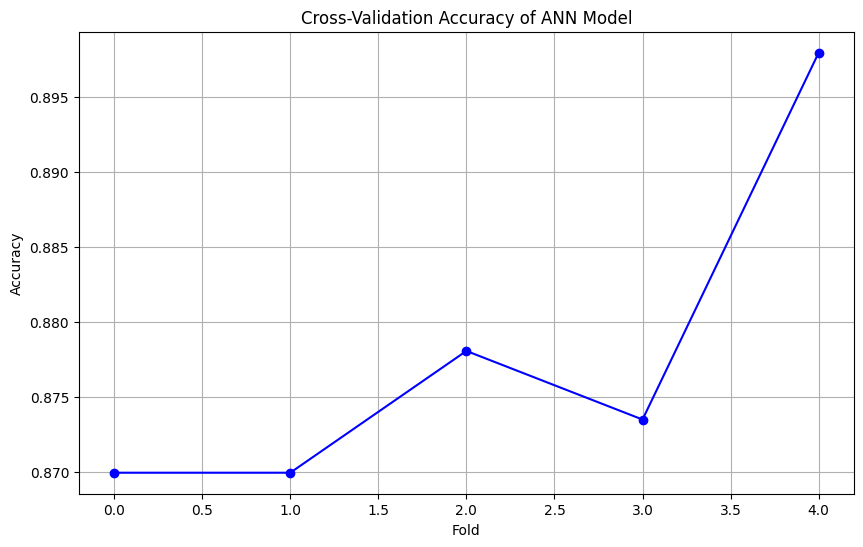

<Figure size 1000x600 with 0 Axes>

In [14]:

import matplotlib.pyplot as plt
# Plot cross-validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(cv_accuracies, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation Accuracy of ANN Model')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)

plt.figure(figsize=(10, 6))




In [15]:
#get precison,accuracy,recall,f1-score
from sklearn.metrics import classification_report
#in tabuluar format
print(classification_report(y_test, y_pred_bin, target_names=['Not Diabetic', 'Diabetic']))


              precision    recall  f1-score   support

Not Diabetic       0.81      0.77      0.79        99
    Diabetic       0.62      0.67      0.64        55

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.72       154
weighted avg       0.74      0.73      0.74       154



In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score



In [17]:
# Initialize models
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()
svc_model = SVC()
gb_model = GradientBoostingClassifier()
nb_model = GaussianNB()



In [18]:
# Train models
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
svc_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)



GaussianNB()

In [19]:
# Predict and calculate accuracy
dt_acc = accuracy_score(y_test, dt_model.predict(X_test))
rf_acc = accuracy_score(y_test, rf_model.predict(X_test))
knn_acc = accuracy_score(y_test, knn_model.predict(X_test))
svc_acc = accuracy_score(y_test, svc_model.predict(X_test))
gb_acc = accuracy_score(y_test, gb_model.predict(X_test))
nb_acc = accuracy_score(y_test, nb_model.predict(X_test))



In [20]:
# Print accuracies
print(f"Decision Tree Accuracy: {dt_acc:.2f}")
print(f"Random Forest Accuracy: {rf_acc:.2f}")
print(f"KNN Accuracy: {knn_acc:.2f}")
print(f"SVM Accuracy: {svc_acc:.2f}")
print(f"Gradient Boosting Accuracy: {gb_acc:.2f}")
print(f"Naive Bayes Accuracy: {nb_acc:.2f}")

Decision Tree Accuracy: 0.75
Random Forest Accuracy: 0.75
KNN Accuracy: 0.69
SVM Accuracy: 0.75
Gradient Boosting Accuracy: 0.75
Naive Bayes Accuracy: 0.77


In [21]:
import plotly.graph_objects as go

# Model names and their accuracies
model_names = ['Decision Tree', 'Random Forest', 'KNN', 'SVM', 'Gradient Boosting', 'Naive Bayes','GAN']
accuracies = [dt_acc, rf_acc, knn_acc, svc_acc, gb_acc, nb_acc,acc_gan_cv]

# Create a horizontal bar chart
fig = go.Figure(go.Bar(
    x=accuracies,
    y=model_names,
    orientation='h',
    marker=dict(color='rgba(50, 171, 96, 0.6)', line=dict(color='rgba(50, 171, 96, 1.0)', width=1))
))

# Update layout for better look
fig.update_layout(
    title='Model Accuracies Comparison',
    xaxis=dict(title='Accuracy'),
    yaxis=dict(title='Model'),
    template='plotly_white'
)


In [22]:
preg=int(input("Enter the number of pregnancies: "))
glucose=int(input("Enter the glucose level: "))
blood_pressure=int(input("Enter the blood pressure: "))
skin_thickness=int(input("Enter the skin thickness: "))
insulin=int(input("Enter the insulin level: "))
bmi=float(input("Enter the BMI: "))
diabetes_pedigree_function=float(input("Enter the diabetes pedigree function: "))
age=int(input("Enter the age: "))
input_data = [preg, glucose, blood_pressure, skin_thickness, insulin, bmi, diabetes_pedigree_function, age]
input_data = np.array(input_data).reshape(1, -1)
input_data = scaler.transform(input_data)





In [24]:

prediction = ann_cv.predict(input_data)
print(f"Prediction: {prediction[0][0]:.2f}")
if prediction[0][0] > 0.5:
    print("Diabetic")
else:
    print("Not Diabetic")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: 1.00
Diabetic
